# **Resumo**

A ideia desse trabalho é criar um algoritmo de *reinforcement learning* que busque atingir o equilíbrio de Nash - quando cada jogador escolhe a melhor ação possível (ótima) dada a estratégia do seu oponente - para leilões de 1o preço, com valorações privadas e independentes.

Mais especificamente, esse modelo de leilão consiste em 2 jogadores que escolhem lances simultaneamente sem o conhecimento do outro jogador. O vencedor do leilão será o jogador que der o maior lance. Antes da escolha do lance , a cada episódio, cada jogador recebe a sua valoração. O jogador não tem a informação prévia da valoração do outro jogador, apenas conhece a sua distribuição de probabilidades (uniforme entre 0 e 1 , com 1 casa decimal). Após cada episódio do leilão, o jogador recebe as seguintes informações: quem venceu o leilão, qual foi o seu ganho (recompensa) e o lance do seu oponente. O objetivo de cada jogador é maximizar a sua utilidade (ganhos/recompensas) a cada episódio e ao longo do tempo.


**Matematicamente:**

objetivo do jogador (agente): escolher o lance(b) que maximize a sua utilidade (recompensa) esperada [(v-b)* G(b)] + [0* (1-G(b))] ; onde G(b) é a probabilidade de vencer o leilão, v é a valoração do jogador
                
Estratégia que corresponde ao equilíbrio de Nash: v/2

Recompensa que corresponde ao equilíbrio de Nash: 1.67


**Implementação:**

Dividimos esse trabalho em 2 partes , baseada no desenho do experimento feito nas sessões base da dissertação de mestrado "Identificando as Causas do Fenômeno de Overbidding em Leilões de Primeiro Preço: Uma Análise Experimental"

https://www2.dbd.puc-rio.br/pergamum/biblioteca/php/mostrateses.php?open=1&arqtese=0610512_08_Indice.html

Parte 1: Apenas um agente está em processo de aprendizado. O outro agente jogará sempre o equilíbrio de Nash (v/2) , o que será de conhecimento do jogador que está aprendendo.

Parte 2: 2 agentes aprendem simultanemente observando ao longo do tempo as ações de seu oponente e atualizando assim , as suas expectativas em relação a probabilidade de vencer o leilão.

# Parte 1: Oponente de Nash

Episódio   10000 | Recompensa: 1.050 | ε: 0.9900
Episódio   20000 | Recompensa: 1.044 | ε: 0.9802
Episódio   30000 | Recompensa: 1.075 | ε: 0.9704
Episódio   40000 | Recompensa: 1.061 | ε: 0.9608
Episódio   50000 | Recompensa: 1.055 | ε: 0.9512
Episódio   60000 | Recompensa: 1.097 | ε: 0.9418
Episódio   70000 | Recompensa: 1.090 | ε: 0.9324
Episódio   80000 | Recompensa: 1.055 | ε: 0.9231
Episódio   90000 | Recompensa: 1.100 | ε: 0.9139
Episódio  100000 | Recompensa: 1.103 | ε: 0.9048
Episódio  110000 | Recompensa: 1.126 | ε: 0.8958
Episódio  120000 | Recompensa: 1.096 | ε: 0.8869
Episódio  130000 | Recompensa: 1.095 | ε: 0.8781
Episódio  140000 | Recompensa: 1.153 | ε: 0.8694
Episódio  150000 | Recompensa: 1.124 | ε: 0.8607
Episódio  160000 | Recompensa: 1.135 | ε: 0.8521
Episódio  170000 | Recompensa: 1.123 | ε: 0.8437
Episódio  180000 | Recompensa: 1.127 | ε: 0.8353
Episódio  190000 | Recompensa: 1.137 | ε: 0.8270
Episódio  200000 | Recompensa: 1.152 | ε: 0.8187
Episódio  210000 | R

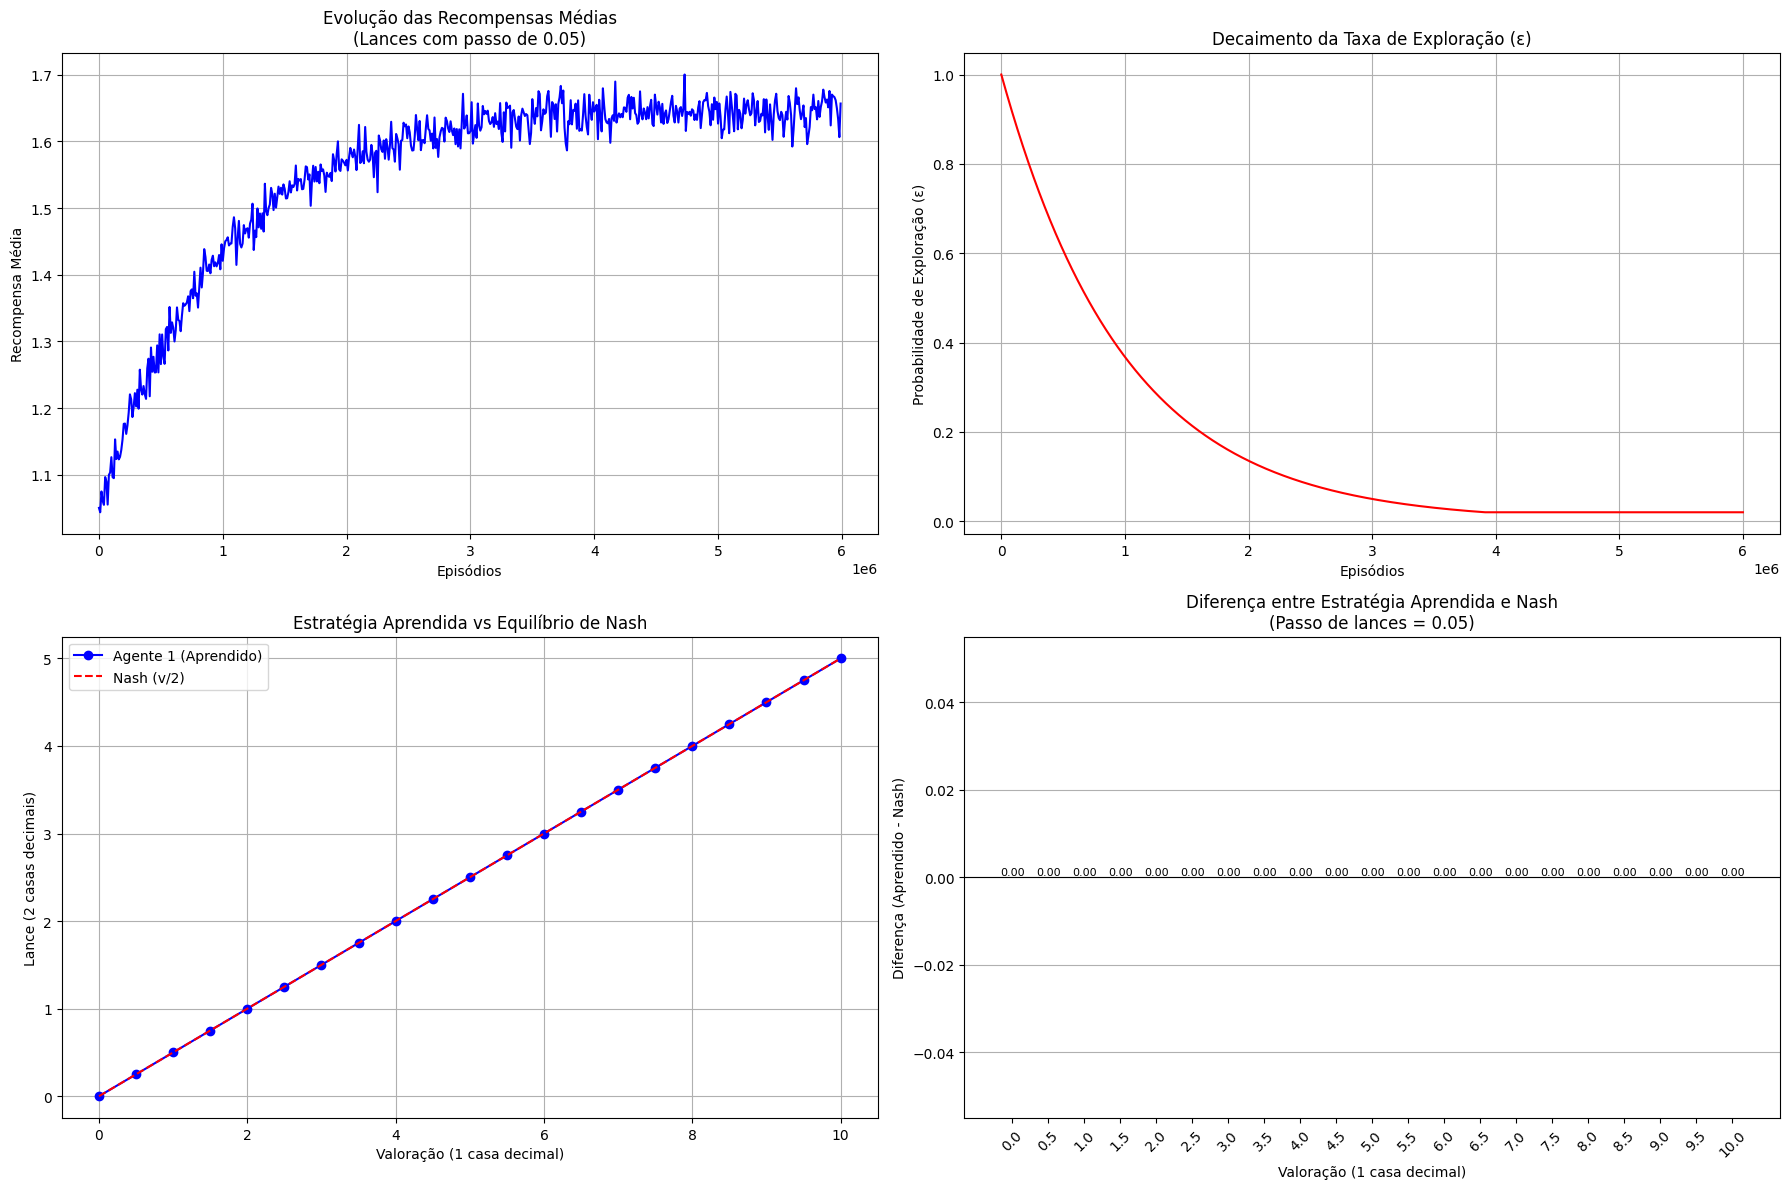

In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Configurações
precisao_valoracao = 1    # 1 casa decimal, conforme definição original do problema
precisao_lance = 2        # 2 casas decimais. Como as valorações tem 1 casa decimal e o equilíbrio de Nash é v/2, são necessárias 2 casas para os lances
passo_lance = 0.05        # Incremento dos lances (0.00, 0.05, 0.10, ..., 9.9,10.0)
num_acoes = int(10.00 / passo_lance) + 1  # 201 ações possíveis

# Inicialização da Q-table
Q1 = defaultdict(lambda: np.zeros(num_acoes))

# Parâmetros do algoritmo
alpha = 0.2               # Taxa de aprendizado
epsilon_inicial = 1.0     # Exploração inicial
epsilon_min = 0.02        # Mínimo de exploração
epsilon_decay = 0.999999  # Decaimento da exploração
num_episodios = 6000000   # Número de episódios
intervalo_relatorio = 10000

# Históricos para análise
historico_recompensas = []
historico_epsilon = []
epsilon = epsilon_inicial

# Função para discretizar lances na Q-table
def discretize(b):
    return int(round(b / passo_lance))

# Agente Nash (estratégia teórica ótima)
def agente_nash(v):
    return round(v / 2, precisao_lance)

# Loop de treinamento
for episodio in range(1, num_episodios + 1):
    v1 = round(np.random.uniform(0, 10), precisao_valoracao) # geração de valoração com 1 casa decimal para agente 1 (que irá aprender)
    v2 = round(np.random.uniform(0, 10), precisao_valoracao) # geração de valoração com 1 casa decimal para agente 2 (agente Nash)

    # Escolha do lance do Agente 1
    if np.random.rand() < epsilon:
        b1 = round(np.random.uniform(0, v1), precisao_lance)  # lances limitados a valoração do agente, escolhidos aleatoriamente
    else:
        # Gera lances candidatos com passo 0.05
        num_acoes = int(v1 / passo_lance) + 1
        b1_opcoes = [round(i * passo_lance, precisao_lance) for i in range(num_acoes)]
        b1 = b1_opcoes[np.argmax([Q1[discretize(v1)][discretize(b)] for b in b1_opcoes])]  # escolhe o lance que maximiza Q(v,b)

    # Agente 2 (Nash)
    b2 = agente_nash(v2)

    # Cálculo da recompensa
    r1 = round((v1 - b1) if b1 > b2 else 0, 2)  # recompensa é igual a valoração menos o lance caso lance seja maior que do oponente e 0 cc
    historico_recompensas.append(r1)

    # Atualização de  Q1
    prob_ganhar = min(b1/5, 1)  # P(ganhar) = P(2*b1>v2)
    delta = (v1 - b1) * prob_ganhar - Q1[discretize(v1)][discretize(b1)]
    Q1[discretize(v1)][discretize(b1)] += alpha * delta

    # Atualização de  epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    historico_epsilon.append(epsilon)

    # Relatório periódico
    if episodio % intervalo_relatorio == 0:
        avg_r = round(np.mean(historico_recompensas[-intervalo_relatorio:]), 3)
        print(f"Episódio {episodio:7d} | Recompensa: {avg_r:.3f} | ε: {epsilon:.4f}")

# Tabela de estratégias aprendidas vs equilíbrio de Nash
print("\nValoração | Agente 1 (Aprendido) | Nash (v/2) | Diferença")
print("-------------------------------------------------------")
valores = [round(v, precisao_valoracao) for v in np.linspace(0, 10, 21)]
diferencas = []
for v in valores:
    v_disc = discretize(v)
    lance_aprendido = round(np.argmax(Q1[v_disc]) * passo_lance, precisao_lance)
    lance_nash = round(v / 2, precisao_lance)
    diferenca = round(lance_aprendido - lance_nash, 2)
    diferencas.append(diferenca)
    print(f"{v:9.1f} | {lance_aprendido:19.2f} | {lance_nash:11.2f} | {diferenca:9.2f}")


# Gráficos
plt.figure(figsize=(18, 12))

# Gráfico 1: Evolução das Recompensas
plt.subplot(2, 2, 1)
episodios = np.arange(0, num_episodios, intervalo_relatorio)[:len(historico_recompensas[::intervalo_relatorio])]
plt.plot(episodios,
         [np.mean(historico_recompensas[i:i+intervalo_relatorio])
          for i in range(0, len(historico_recompensas), intervalo_relatorio)],
         'b-')
plt.title('Evolução das Recompensas Médias\n(Lances com passo de 0.05)', fontsize=12)
plt.xlabel('Episódios', fontsize=10)
plt.ylabel('Recompensa Média', fontsize=10)
plt.grid(True)

# Gráfico 2: Decaimento do Epsilon
plt.subplot(2, 2, 2)
plt.plot(historico_epsilon, 'r-')
plt.title('Decaimento da Taxa de Exploração (ε)', fontsize=12)
plt.xlabel('Episódios', fontsize=10)
plt.ylabel('Probabilidade de Exploração (ε)', fontsize=10)
plt.grid(True)

# Gráfico 3: Estratégia Aprendida vs Nash(v/2 ; reta 45o)
plt.subplot(2, 2, 3)
aprendido = [round(np.argmax(Q1[discretize(v)]) * passo_lance, precisao_lance) for v in valores]
nash = [round(v / 2, precisao_lance) for v in valores]
plt.plot(valores, aprendido, 'bo-', label="Agente 1 (Aprendido)")
plt.plot(valores, nash, 'r--', label="Nash (v/2)")
plt.xlabel('Valoração (1 casa decimal)', fontsize=10)
plt.ylabel('Lance (2 casas decimais)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.title('Estratégia Aprendida vs Equilíbrio de Nash', fontsize=12)

# Gráfico 4: Estratégia Aprendida vs Nash em barras
plt.subplot(2, 2, 4)
bars = plt.bar([f"{v:.1f}" for v in valores], diferencas, width=0.6,
               color=['red' if d < 0 else 'blue' for d in diferencas])
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Diferença entre Estratégia Aprendida e Nash\n(Passo de lances = 0.05)', fontsize=12)
plt.xlabel('Valoração (1 casa decimal)', fontsize=10)
plt.ylabel('Diferença (Aprendido - Nash)', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom' if height >=0 else 'top',
             fontsize=8, color='black')

plt.tight_layout()
plt.show()

# Parte 2:  2 agentes aprendendo simultaneamente

A estratégia de exploração foi alterada para Boltzmann , já que o e-greedy nao funcionou tão bem para aprendizado de 2 agentes, mostrando resultados mais distantes do equilíbrio de Nash. Ainda assim, mesmo com a mudança, os agentes não chegaram no equilíbrio de Nash exato, embora tenham ficado bem próximo dele.

No algoritmo de 2 agentes , o aprendizado e atualização, ao longo do processo, da probabilidade de vencer o leilão fundamentais para a convergência próxima ao equilíbrio de Nash.


Episódio 10000 | R1: 1.36 | R2: 1.31 | τ: 0.9954 | Métrica: 108.65 (0.2703)| Métrica Ag1: 53.65 | Ag2: 55.00
Episódio 20000 | R1: 1.45 | R2: 1.47 | τ: 0.9908 | Métrica: 88.60 (0.2204)| Métrica Ag1: 44.70 | Ag2: 43.90
Episódio 30000 | R1: 1.51 | R2: 1.50 | τ: 0.9863 | Métrica: 79.15 (0.1969)| Métrica Ag1: 39.85 | Ag2: 39.30
Episódio 40000 | R1: 1.52 | R2: 1.53 | τ: 0.9817 | Métrica: 75.35 (0.1874)| Métrica Ag1: 37.90 | Ag2: 37.45
Episódio 50000 | R1: 1.51 | R2: 1.53 | τ: 0.9772 | Métrica: 73.95 (0.1840)| Métrica Ag1: 37.85 | Ag2: 36.10
Episódio 60000 | R1: 1.50 | R2: 1.57 | τ: 0.9727 | Métrica: 71.50 (0.1779)| Métrica Ag1: 34.55 | Ag2: 36.95
Episódio 70000 | R1: 1.52 | R2: 1.56 | τ: 0.9683 | Métrica: 76.00 (0.1891)| Métrica Ag1: 36.60 | Ag2: 39.40
Episódio 80000 | R1: 1.53 | R2: 1.56 | τ: 0.9638 | Métrica: 69.00 (0.1716)| Métrica Ag1: 32.65 | Ag2: 36.35
Episódio 90000 | R1: 1.54 | R2: 1.55 | τ: 0.9594 | Métrica: 69.60 (0.1731)| Métrica Ag1: 31.75 | Ag2: 37.85
Episódio 100000 | R1: 1.51 

<Figure size 1200x500 with 0 Axes>

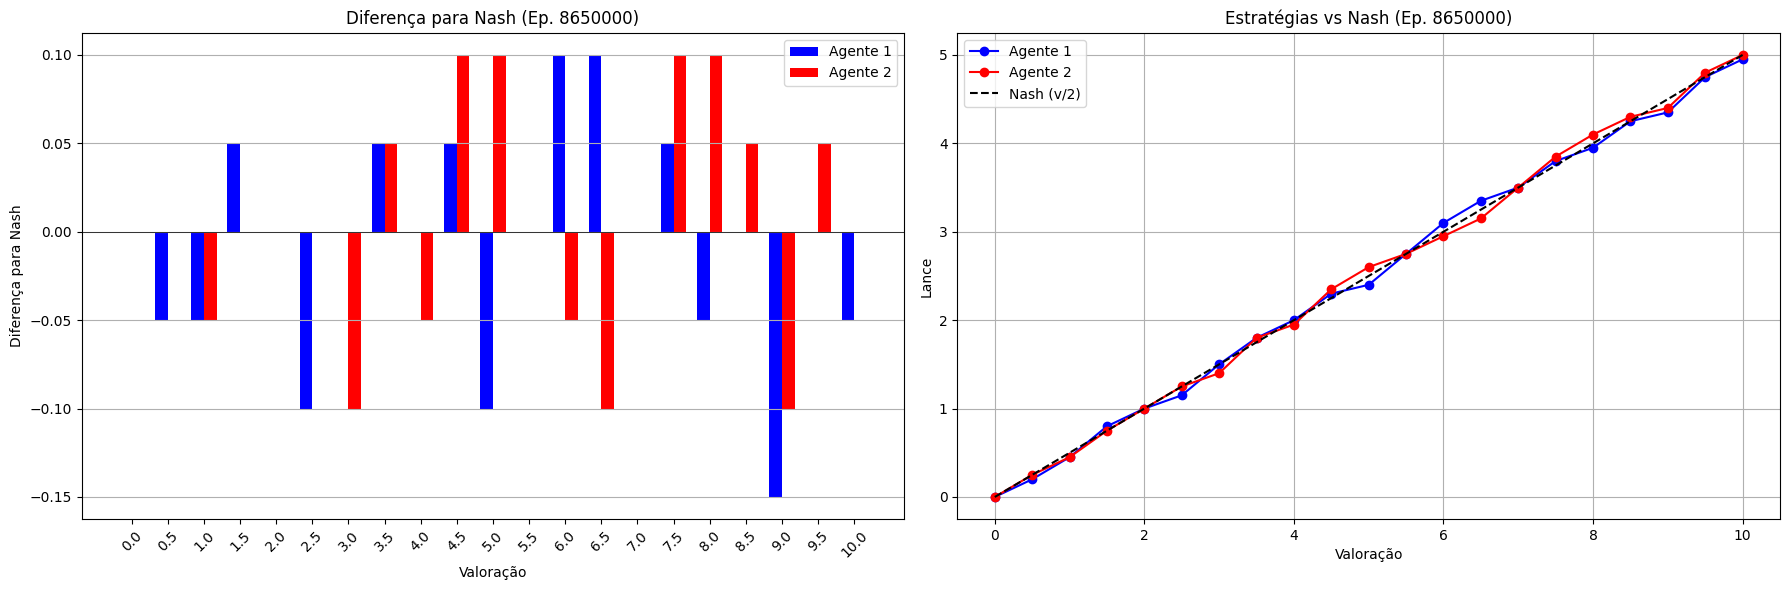

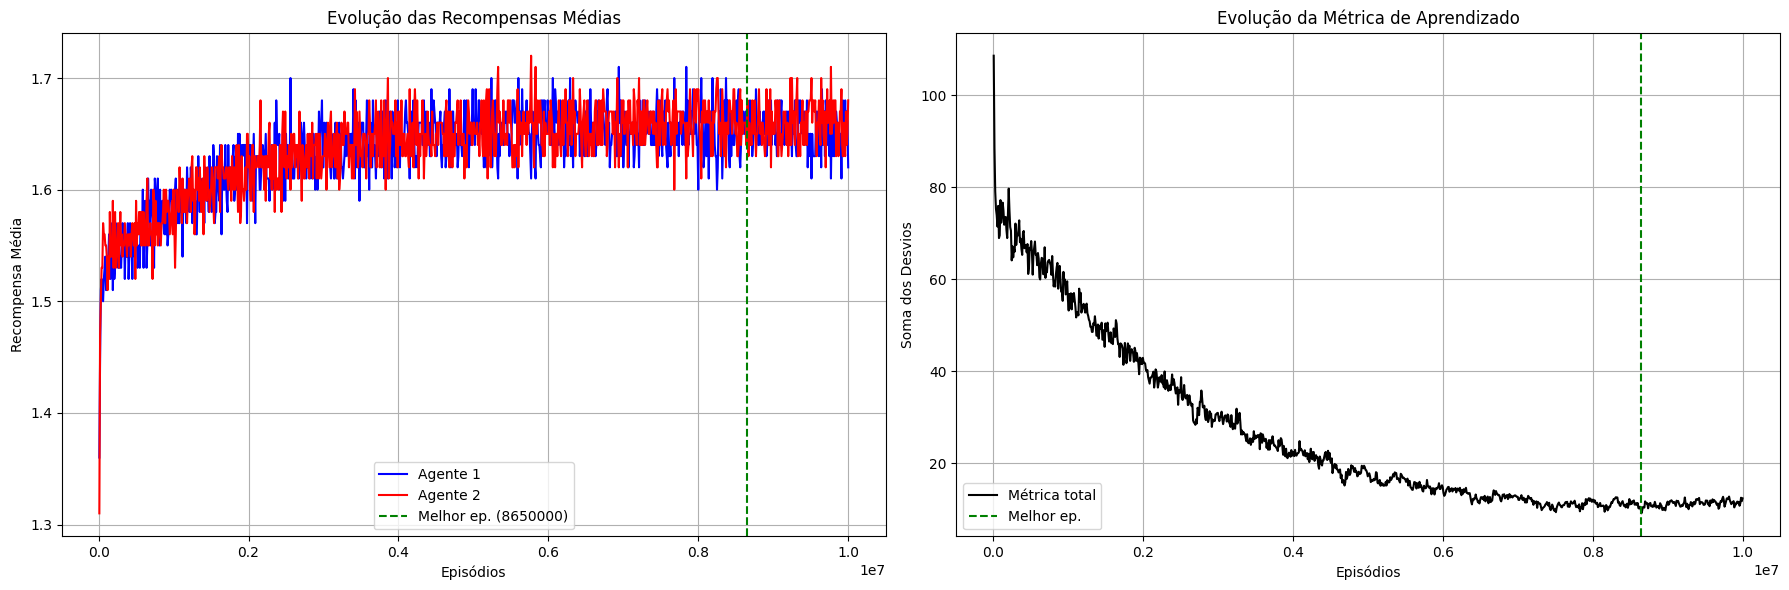

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


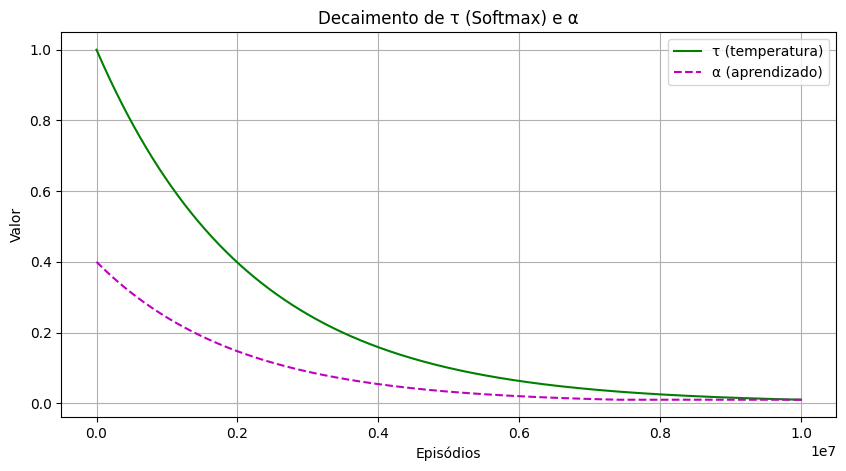

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import copy

# Configurações
precisao_lance = 2
passo_lance = 0.05
num_acoes = int(10.00 / passo_lance) + 1

# Inicialização das tabelas Q
Q1 = defaultdict(lambda: np.zeros(num_acoes))
Q2 = defaultdict(lambda: np.zeros(num_acoes))

# Parâmetros do algoritmo
alpha_inicial = 0.4       # Taxa de aprendizado
alpha_min = 0.01          # mínimo da taxa de aprendizado
alpha_decay = 0.9999995   # taxa de decaimento do aprendizado
alpha = alpha_inicial

#Temperatura (Boltzmann)
tau_init = 1.0
tau_min = 0.01
num_episodios = 10000000
intervalo_relatorio = 10000
tau_decay = (tau_min / tau_init) ** (1.0 / num_episodios)
tau = tau_init

# Históricos para análise
historico_recompensas_1 = []
historico_recompensas_2 = []
media_recompensas_1 = []
media_recompensas_2 = []
historico_tau = []
historico_alpha = []
historico_metricas = []
lances_agente1 = []
lances_agente2 = []

# Controle da melhor métrica
melhor_metrica = float('inf')
melhor_episodio = 0
melhor_Q1 = None
melhor_Q2 = None

# Funções

# Função para discretizar lances na Q-table
def discretize(b):
    return min(int(round(b / passo_lance)), num_acoes - 1)

# Função para estimar a probabilidade de vencer o leilão empiricamente
def estimar_prob_ganhar(lance, lances_oponente, window_size=500):
    if not lances_oponente:
        return min(lance/5, 1)
    recent_bids = lances_oponente[-window_size:]   # é usada uma janela recente de lances já que os agentes vão aprendendo ao longo do tempo
    return np.mean(np.array(recent_bids) < lance)  # calcula-se empiricamente a prob de vitória considerando o % de vezes lance atual foi maior que o lance do oponente

def gerar_lances(v):
    n_acoes = min(int(v / passo_lance) + 1, num_acoes)
    return [round(i * passo_lance, precisao_lance) for i in range(n_acoes)]

def escolher_acao_softmax(q_vals, poss_indices, tau):
    qf = q_vals[poss_indices]
    exp_vals = np.exp((qf - np.max(qf)) / tau)
    probs = exp_vals / exp_vals.sum()
    return np.random.choice(poss_indices, p=probs)

# Função que cálcula uma métrica de aprendizado (desvios absolutos entre o melhor lance aprendido na tabela Q e o equilibrio de Nash)
def calcular_metrica_aprendizado(Q):
    valores = np.round(np.arange(0, 10.1, 0.1), 1)
    soma_desvios = 0.0
    for v in valores:
        v_disc = discretize(v)
        lance_aprendido = np.argmax(Q[v_disc]) * passo_lance
        soma_desvios += abs(lance_aprendido - v/2)
    return soma_desvios

# Treinamento
for episodio in range(1, num_episodios + 1):
    v1 = round(np.random.uniform(0, 10), 1)
    v2 = round(np.random.uniform(0, 10), 1)

    b1_opcoes = gerar_lances(v1)
    b1_indices = [discretize(b) for b in b1_opcoes]
    b1_idx = escolher_acao_softmax(Q1[discretize(v1)], b1_indices, tau)
    b1 = round(b1_idx * passo_lance, precisao_lance)

    b2_opcoes = gerar_lances(v2)
    b2_indices = [discretize(b) for b in b2_opcoes]
    b2_idx = escolher_acao_softmax(Q2[discretize(v2)], b2_indices, tau)
    b2 = round(b2_idx * passo_lance, precisao_lance)

    if b1 > b2:
        r1, r2 = round(v1 - b1, 2), 0
    elif b2 > b1:
        r1, r2 = 0, round(v2 - b2, 2)
    else:
        r1, r2 = (round(v1 - b1, 2), 0) if np.random.rand() < 0.5 else (0, round(v2 - b2, 2))  #sorteio em caso de empate

    historico_recompensas_1.append(r1)
    historico_recompensas_2.append(r2)
    lances_agente1.append(b1)
    lances_agente2.append(b2)

    prob_ganhar_1 = estimar_prob_ganhar(b1, lances_agente2)
    recompensa_esperada_1 = (v1 - b1) * prob_ganhar_1
    Q1[discretize(v1)][discretize(b1)] += alpha * (recompensa_esperada_1 - Q1[discretize(v1)][discretize(b1)])

    prob_ganhar_2 = estimar_prob_ganhar(b2, lances_agente1)
    recompensa_esperada_2 = (v2 - b2) * prob_ganhar_2
    Q2[discretize(v2)][discretize(b2)] += alpha * (recompensa_esperada_2 - Q2[discretize(v2)][discretize(b2)])

    tau = max(tau_min, tau * tau_decay)
    alpha = max(alpha_min, alpha * alpha_decay)
    historico_tau.append(tau)
    historico_alpha.append(alpha)

    if episodio % intervalo_relatorio == 0:
        metrica1 = calcular_metrica_aprendizado(Q1)
        metrica2 = calcular_metrica_aprendizado(Q2)
        metrica_total = metrica1 + metrica2
        metrica_media = metrica_total / (num_acoes*2)  #média por ação de desvio do lance aprendido em relação ao eq de Nash
        historico_metricas.append(metrica_total)

        if metrica_total < melhor_metrica:
            melhor_metrica = metrica_total
            melhor_episodio = episodio
            melhor_Q1 = copy.deepcopy(Q1)
            melhor_Q2 = copy.deepcopy(Q2)

        avg_r1 = round(np.mean(historico_recompensas_1[-intervalo_relatorio:]), 2)
        avg_r2 = round(np.mean(historico_recompensas_2[-intervalo_relatorio:]), 2)
        media_recompensas_1.append(avg_r1)
        media_recompensas_2.append(avg_r2)
        print(f"Episódio {episodio} | R1: {avg_r1:.2f} | R2: {avg_r2:.2f} | τ: {tau:.4f} | "
              f"Métrica: {metrica_total:.2f} ({metrica_media:.4f})| Métrica Ag1: {metrica1:.2f} | Ag2: {metrica2:.2f}")

# Resultados com melhor métrica
valores = [round(v, 1) for v in np.arange(0, 10.5, 0.5)]
plt.figure(figsize=(12, 5))


print(f"\n=== Melhor desempenho no episódio {melhor_episodio} ===")
print(f"Métrica total (Ag1 + Ag2): {melhor_metrica:.2f}")

valores = [round(v, 1) for v in np.arange(0, 10.5, 0.5)]
print("\nValoração | Agente 1 (Melhor) | Agente 2 (Melhor) | Nash (v/2) | Dif. Ag1 | Dif. Ag2")
print("-------------------------------------------------------------------------------")
for v in valores:
    v_disc = discretize(v)
    l1 = np.argmax(melhor_Q1[v_disc]) * passo_lance
    l2 = np.argmax(melhor_Q2[v_disc]) * passo_lance
    nash = v/2
    print(f"{v:9.1f} | {l1:16.2f} | {l2:16.2f} | {nash:9.2f} | {l1-nash:7.2f} | {l2-nash:7.2f}")

# Gráficos
plt.figure(figsize=(18, 6))

# Gráfico 1: Diferenças para Nash
diffs1 = [np.argmax(melhor_Q1[discretize(v)]) * passo_lance - v/2 for v in valores]
diffs2 = [np.argmax(melhor_Q2[discretize(v)]) * passo_lance - v/2 for v in valores]
plt.subplot(1, 2, 1)
width = 0.35
x = np.arange(len(valores))
plt.bar(x - width/2, diffs1, width, label='Agente 1', color='blue')
plt.bar(x + width/2, diffs2, width, label='Agente 2', color='red')
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(x, valores, rotation=45)
plt.title(f"Diferença para Nash (Ep. {melhor_episodio})")
plt.xlabel("Valoração")
plt.ylabel("Diferença para Nash")
plt.legend()
plt.grid(True, axis='y')

# Gráfico 2: Estratégias vs Nash
plt.subplot(1, 2, 2)
lances1 = [np.argmax(melhor_Q1[discretize(v)]) * passo_lance for v in valores]
lances2 = [np.argmax(melhor_Q2[discretize(v)]) * passo_lance for v in valores]
nash = [v/2 for v in valores]
plt.plot(valores, lances1, 'bo-', label="Agente 1")
plt.plot(valores, lances2, 'ro-', label="Agente 2")
plt.plot(valores, nash, 'k--', label="Nash (v/2)")
plt.title(f"Estratégias vs Nash (Ep. {melhor_episodio})")
plt.xlabel("Valoração")
plt.ylabel("Lance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Subplot 1: Evolução das recompensas
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
x_vals = [i * intervalo_relatorio for i in range(1, len(media_recompensas_1) + 1)]
plt.plot(x_vals, media_recompensas_1, 'b-', label="Agente 1")
plt.plot(x_vals, media_recompensas_2, 'r-', label="Agente 2")
plt.axvline(x=melhor_episodio, color='g', linestyle='--', label=f"Melhor ep. ({melhor_episodio})")
plt.title("Evolução das Recompensas Médias")
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.legend()
plt.grid(True)

# Subplot 2: Evolução da métrica
plt.subplot(1, 2, 2)
x_m = [i * intervalo_relatorio for i in range(1, len(historico_metricas) + 1)]
plt.plot(x_m, historico_metricas, 'k-', label="Métrica total")
plt.axvline(x=melhor_episodio, color='g', linestyle='--', label="Melhor ep.")
plt.title("Evolução da Métrica de Aprendizado")
plt.xlabel("Episódios")
plt.ylabel("Soma dos Desvios")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Gráfico: Decaimento do τ e α
plt.figure(figsize=(10, 5))
plt.plot(historico_tau, 'g-', label="τ (temperatura)")
plt.plot(historico_alpha, 'm--', label="α (aprendizado)")
plt.title("Decaimento de τ (Softmax) e α")
plt.xlabel("Episódios")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()